##Import and File handling 

In [ ]:
from google.colab import drive 
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torchvision import datasets 
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

torch.cuda.empty_cache()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# getting dataset from folder 
drive.mount('/content/drive')

# data_dir = '/content/drive/My Drive/fruits'
data_dir = 'herbs'
# data_dir = '208x256'

Sun Apr  3 14:16:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Unzipping and stuff

In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/herbs.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

!ls
!rmdir ./herbs/.ipynb_checkpoints/

Done
drive  herbs  __MACOSX	sample_data
rmdir: failed to remove './herbs/.ipynb_checkpoints/': No such file or directory


## GPU retrieval

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Models


In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(5, 5),

            nn.Flatten(), 
            nn.Linear(25600, 1024),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(512, 131))  
            
        
    def forward(self, xb):
        return self.network(xb)

# Our own CNN
cnnModel = NeuralNet()
cnnModel.to(device)

# The rest of the models
dnet121 = models.densenet121(pretrained=True)
rnet18 = models.resnet18(pretrained=True)
gnet = models.googlenet(pretrained=True)
dnet121.to(device)
rnet18.to(device)
gnet.to(device)
print('models moved to...', device)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

models moved to... cuda:0


### Fruits Data

In [ ]:

# Initially tot I'd need more transform voodoo magic, but nah I just need ToTensor
transform = transforms.Compose(
[
    transforms.RandomHorizontalFlip(), # new
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# Magic loading of datasets from our fruits folder, then apply the transform voodoo
fruit_data = datasets.ImageFolder(data_dir, transform=transform) 

# Splitting the fruit_data into train and test; 90% and 10%
train_size = int(0.9 * len(fruit_data))
test_size = len(fruit_data) - train_size 

train_dataset, test_dataset = torch.utils.data.random_split(fruit_data, [train_size, test_size])


In [ ]:
# classes = ["Apple", "Banana", "Grape", "Mango", "Strawberry"]
old_classes = [
	"Apple",
	"Banana",
	"Blueberry",
	"Cherry",
	"Cocoa Bean",
	"Coconut",
	"Date",
	"Dragonfruit",
	"Durian",
	"Eggplant",
	"Goji",
	"Grape",
	"Jackfruit",
	"Kiwi",
	"Langsat",
	"Lemon",
	"Longan",
	"Lychee",
	"Mango",
	"Orange",
	"Papaya",
	"Pineapple",
	"Pumpkin",
	"Rambutan",
	"Strawberry",
	"Watermelon"
]

classes = ['Puffball', 'Gastrodia', 'Northern Ginseng', 'Rhubarb', 'Dried Ginger', 'Achyranthes', 'Sophora Flavescens', 'Red Sage', 'Stemona Tuberosa', 'White Aconite', 'white peony', 'Angelica', 'Atractylodes', 'Morinda', 'Aconitum Carmichaelii', 'Bupleurum', 'Atractylodes', 'Red Peony', 'Achyranthes', 'Common Monkshood Mother Root', 'Szechwan Lovage Rhizome', 'Angelica', 'Rehmannia Glutinosa', 'Angelica Pubescens', 'Windproof', 'Stephania Tetrandra', 'Aconite', 'Galangal', 'Pueraria', 'Coptis', 'Astragalus', 'Baikal Skullcap', 'Neopicrorhiza Scrophulariiflora', 'Bellflower', 'Reed Root', 'Dwarf Lilyturf', 'Saussurea Costus', 'Notopterygium Incisum', 'Whiteflower Hogfennel Root', 'Gentiana Macrophylla', 'Blackberry Lily', 'Cimicifuga', 'Japanese Sweet Flag', 'Asparagus', 'Trichosanthin', 'Lindera Aggregata', 'Cymbidium', 'Scallion White', 'Asarum', 'American Ginseng', 'Scrophularia', 'Corydalis Yanhusuo', 'Yuanzhi', 'Polygonatum', 'Common water-plantain', 'Anemarrhena', 'Aster', 'Licorice', 'Pinellia', 'ramulus cinnamomi', 'Chocolate Vine', 'Mulberry Mistletoe', 'White Lentils', 'Ginkgo', 'Piper', 'Betel Nut', 'Psoralea', 'Grass Cardamom', 'Grass Fruit', 'Chenpi', 'Psyllium', 'Red Bean', 'Arece Peel', 'Light Tempeh', 'Jujube', 'Gualou', 'Forsythia', 'Longan meat', 'Malt', 'Vitex', 'Papaya', 'Green Leather', 'Nutmeg', 'Hawthorn', 'peach kernel', 'Schisandra', 'Evodia', 'Cumin', 'Coix Seed', 'Citrus Aurantium', 'Citrus Aurantium', 'Gardenia', 'Goji Berries', 'Gorgon', 'cornelian cherry', 'Smoked plum', 'Neem', 'Burdock', 'Amomum', 'Mint', 'Cirsium Japonicum', 'Creeping Thistle', 'Fineleaf Schizonepeta Herb', 'Chinese Ephedrs Herb', 'Artemisia Annua', 'Dianthus Superbus', 'Dendrobium', 'Oriental Motherwort', 'Capillary Wormwood', 'Cloves', 'Honeysuckle', 'Common Coltsfoot Flower', 'Safflower', 'Inula flower', 'Arborvitae Leaf', 'Mulberry Leaf', 'Perilla Leaves', 'Lily', 'EEucommia Ulmoides', 'Peony Bark', 'Cinnamon', 'Mulberry White Bark', 'China Root', 'Myrrh', 'Frankincense', 'Rhus Rhinensis', 'Agarwood', 'Southern Dates', 'Codonopsis Pilosula', 'Tuber Fleeceflower', 'Rehmannia Glutinosa']
print(len(classes))

131


2647
torch.Size([16, 3, 200, 200])
It is: [28] Pueraria
28


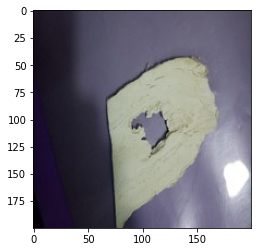

In [ ]:
train_data = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = 16, shuffle=True)
images, labels = next(iter(train_data))

print(len(train_data))

print(images.shape)

# Transpose is needed to show the image. However, training doesn't require the shape required by matplotlib (why, idk)
plt.imshow(images[0].numpy().transpose((1,2,0)))
# print("It is:", classes[labels[0].item()])
print("It is:", [labels[0].item()], classes[labels[0].item()])
print(labels[0].item())
plt.show()

In [ ]:
# num_ftrs = model.fc.in_features
# print(dnet121)
num_ftrs = dnet121.classifier.in_features
dnet121.fc = nn.Linear(num_ftrs, 1024)
dnet121.fc = nn.Linear(dnet121.fc.out_features, 131)
# model.fc = nn.Linear(model.fc.out_features, 262)
dnet121.fc = dnet121.fc.cuda()

# print(rnet18)
num_ftrs = rnet18.fc.in_features
rnet18.fc = nn.Linear(num_ftrs, 512)
rnet18.fc = nn.Linear(rnet18.fc.out_features, 131)
# model.fc = nn.Linear(resnet18.fc.out_features, 262)
rnet18.fc = rnet18.fc.cuda()

num_ftrs = gnet.fc.in_features
gnet.fc = nn.Linear(num_ftrs, 1024)
gnet.fc = nn.Linear(gnet.fc.out_features, 131)
# model.fc = nn.Linear(gnet.fc.out_features, 262)
gnet.fc = gnet.fc.cuda()

### Training and Stuff

In [ ]:
# Optimizer and loss function
optimizer = torch.optim.Adam(dnet121.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [ ]:
BATCH_SIZE = 16
EPOCHS = 10

tr_loss = []
tr_acc = []

import numpy as np

def train(model):
    model.train()
    total = 0
    correct = 0
    batch_loss = 0
# Training time
    # for epoch in tqdm(range(epochs)):
    for batches, (data, target) in (enumerate(train_data)):

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = loss_function(outputs, target)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()

        #measure accuracy of training
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
    tr_acc.append(100 * correct/total)
    tr_loss.append(batch_loss/len(train_data))
    
    print(f"Epoch: {epoch+1}. Loss: {loss}. Accuracy: {100 * correct/total}")
  
val_loss = []
val_acc = []

def test(model):
    vbatch_loss = 0
    vtotal = 0
    vcorrect = 0
    model.eval()
    with torch.no_grad():
            
            for data, target in (test_data):
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = loss_function(outputs, target)
                vbatch_loss += loss.item()
                _, predicted = outputs.max(1)
                vcorrect += predicted.eq(target).sum().item()
                # _,pred = torch.max(outputs, dim=1)
                # vcorrect += torch.sum(pred==target).item()
                vtotal += target.size(0)
            val_acc.append(100 * vcorrect/vtotal)
            val_loss.append(vbatch_loss/len(test_data))
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * vcorrect/vtotal):.4f}\n')

In [ ]:
def grph_plot(tr_acc, val_acc, tr_loss, val_loss):
  plt.plot(tr_acc,'-o')
  plt.plot(val_acc,'-o')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')                   
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Accuracy')

  plt.show()

  plt.plot(tr_loss,'-o')
  plt.plot(val_loss,'-o')
  plt.xlabel('epoch')
  plt.ylabel('losses')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Losses')

  plt.show()


In [ ]:
epoch = 10

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.5018088817596436. Accuracy: 42.13695395513577


 10%|█         | 1/10 [06:31<58:43, 391.55s/it]

validation loss: 0.9506, validation acc: 71.7807

Epoch: 11. Loss: 1.1536418199539185. Accuracy: 75.47815820543093


 20%|██        | 2/10 [12:49<51:08, 383.59s/it]

validation loss: 0.8588, validation acc: 77.6881

Epoch: 11. Loss: 0.5436574816703796. Accuracy: 82.51239669421487


 30%|███       | 3/10 [19:07<44:26, 380.87s/it]

validation loss: 0.7267, validation acc: 85.6354

Epoch: 11. Loss: 0.23385579884052277. Accuracy: 86.23848878394332


 40%|████      | 4/10 [25:24<37:57, 379.56s/it]

validation loss: 0.6102, validation acc: 91.5640

Epoch: 11. Loss: 0.19169405102729797. Accuracy: 88.74852420306966


 50%|█████     | 5/10 [31:43<31:36, 379.25s/it]

validation loss: 0.5716, validation acc: 87.3778

Epoch: 11. Loss: 0.7893107533454895. Accuracy: 90.49586776859505


 60%|██████    | 6/10 [38:00<25:14, 378.54s/it]

validation loss: 0.5264, validation acc: 90.0340

Epoch: 11. Loss: 0.18433749675750732. Accuracy: 91.64580873671783


 70%|███████   | 7/10 [44:16<18:53, 377.70s/it]

validation loss: 0.5178, validation acc: 85.9116

Epoch: 11. Loss: 0.08738638460636139. Accuracy: 92.3801652892562


 80%|████████  | 8/10 [50:35<12:36, 378.04s/it]

validation loss: 0.4820, validation acc: 93.0302

Epoch: 11. Loss: 0.4517040550708771. Accuracy: 93.16410861865407


 90%|█████████ | 9/10 [56:54<06:18, 378.33s/it]

validation loss: 0.4540, validation acc: 93.0514

Epoch: 11. Loss: 0.5121824145317078. Accuracy: 94.1180637544274


100%|██████████| 10/10 [1:03:13<00:00, 379.31s/it]

validation loss: 0.4277, validation acc: 94.1564



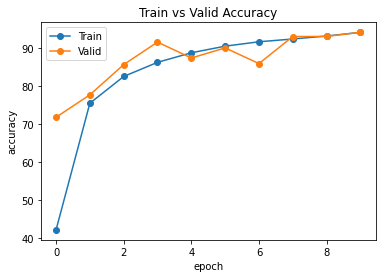

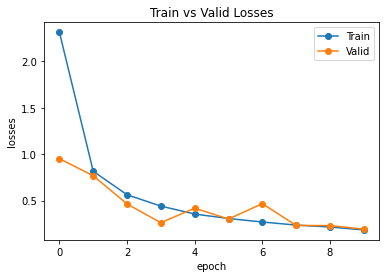

In [ ]:

for i in tqdm(range(epoch)):
  train(dnet121)
  test(dnet121)

grph_plot(tr_acc, val_acc, tr_loss, val_loss)

val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11. Loss: 1.1810016632080078. Accuracy: 76.4887839433294


 10%|█         | 1/10 [02:41<24:13, 161.55s/it]

validation loss: 0.5797, validation acc: 82.0442

Epoch: 11. Loss: 0.3617013990879059. Accuracy: 82.42030696576151


 20%|██        | 2/10 [05:20<21:20, 160.06s/it]

validation loss: 0.5041, validation acc: 86.3578

Epoch: 11. Loss: 0.8731042146682739. Accuracy: 85.26800472255017


 30%|███       | 3/10 [07:59<18:36, 159.55s/it]

validation loss: 0.5200, validation acc: 83.7017

Epoch: 11. Loss: 0.03410763293504715. Accuracy: 87.61747343565526


 40%|████      | 4/10 [10:38<15:55, 159.26s/it]

validation loss: 0.4619, validation acc: 91.0965

Epoch: 11. Loss: 0.8230310082435608. Accuracy: 89.07910271546635


 50%|█████     | 5/10 [13:17<13:15, 159.10s/it]

validation loss: 0.4241, validation acc: 91.4152

Epoch: 11. Loss: 0.18084228038787842. Accuracy: 90.31168831168831


 60%|██████    | 6/10 [15:55<10:36, 159.02s/it]

validation loss: 0.3981, validation acc: 91.3302

Epoch: 11. Loss: 0.11620397865772247. Accuracy: 91.46399055489965


 70%|███████   | 7/10 [18:34<07:56, 158.88s/it]

validation loss: 0.3756, validation acc: 92.4352

Epoch: 11. Loss: 0.083426333963871. Accuracy: 92.13223140495867


 80%|████████  | 8/10 [21:13<05:17, 158.79s/it]

validation loss: 0.3689, validation acc: 90.3740

Epoch: 11. Loss: 0.09411364793777466. Accuracy: 93.00118063754428


 90%|█████████ | 9/10 [23:51<02:38, 158.74s/it]

validation loss: 0.3534, validation acc: 93.0939

Epoch: 11. Loss: 0.12108679115772247. Accuracy: 93.58441558441558


100%|██████████| 10/10 [26:30<00:00, 159.03s/it]

validation loss: 0.3404, validation acc: 93.1577



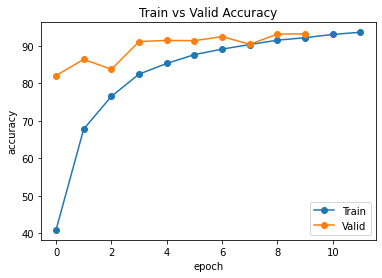

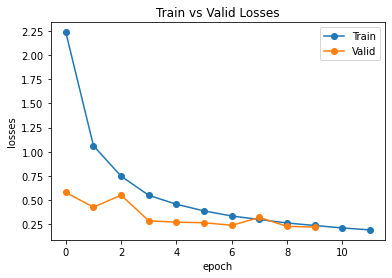

In [ ]:
optimizer = torch.optim.Adam(rnet18.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for i in tqdm(range(epoch)):
  train(rnet18)
  test(rnet18)

grph_plot(tr_acc, val_acc, tr_loss, val_loss)

val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.8410757780075073. Accuracy: 49.09327036599764


 10%|█         | 1/10 [03:26<30:56, 206.32s/it]

validation loss: 0.9240, validation acc: 71.8020

Epoch: 11. Loss: 0.1461181342601776. Accuracy: 74.1629279811098


 20%|██        | 2/10 [06:49<27:14, 204.35s/it]

validation loss: 0.7241, validation acc: 83.3829

Epoch: 11. Loss: 0.6229537129402161. Accuracy: 80.58795749704841


 30%|███       | 3/10 [10:11<23:42, 203.23s/it]

validation loss: 0.6219, validation acc: 86.6341

Epoch: 11. Loss: 0.3614492118358612. Accuracy: 84.25265643447462


 40%|████      | 4/10 [13:35<20:21, 203.59s/it]

validation loss: 0.5855, validation acc: 85.2104

Epoch: 11. Loss: 0.151851087808609. Accuracy: 86.55489964580873


 50%|█████     | 5/10 [16:58<16:57, 203.42s/it]

validation loss: 0.5248, validation acc: 91.0965

Epoch: 11. Loss: 0.6361384391784668. Accuracy: 88.7012987012987


 60%|██████    | 6/10 [20:20<13:31, 202.93s/it]

validation loss: 0.4941, validation acc: 89.0778

Epoch: 11. Loss: 0.45342937111854553. Accuracy: 89.9504132231405


 70%|███████   | 7/10 [23:42<10:07, 202.50s/it]

validation loss: 0.4575, validation acc: 92.3289

Epoch: 11. Loss: 0.03711995854973793. Accuracy: 91.3034238488784


 80%|████████  | 8/10 [27:03<06:44, 202.13s/it]

validation loss: 0.4289, validation acc: 92.4564

Epoch: 11. Loss: 0.25209832191467285. Accuracy: 91.73081463990555


 90%|█████████ | 9/10 [30:24<03:21, 201.86s/it]

validation loss: 0.4039, validation acc: 93.6252

Epoch: 11. Loss: 0.4916483461856842. Accuracy: 92.81227863046045


100%|██████████| 10/10 [33:45<00:00, 202.55s/it]

validation loss: 0.3886, validation acc: 91.9890



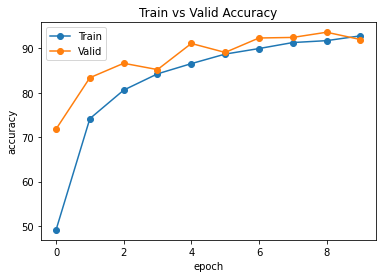

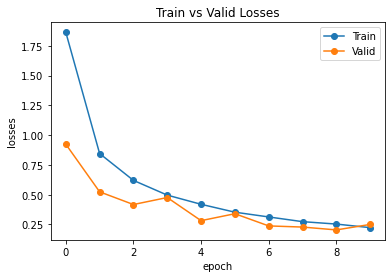

In [ ]:
optimizer = torch.optim.Adam(gnet.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
for i in tqdm(range(epoch)):
  train(gnet)
  test(gnet)

grph_plot(tr_acc, val_acc, tr_loss, val_loss)

val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 21. Loss: 4.858545780181885. Accuracy: 1.3931523022432113


  5%|▌         | 1/20 [03:52<1:13:34, 232.37s/it]

validation loss: 4.8461, validation acc: 1.4450

Epoch: 21. Loss: 4.6821441650390625. Accuracy: 1.4002361275088548


 10%|█         | 2/20 [07:44<1:09:37, 232.08s/it]

validation loss: 4.8413, validation acc: 1.1262

Epoch: 21. Loss: 4.755008220672607. Accuracy: 1.5466351829988194


 15%|█▌        | 3/20 [11:36<1:05:43, 231.97s/it]

validation loss: 4.7985, validation acc: 2.4012

Epoch: 21. Loss: 4.336031913757324. Accuracy: 2.524203069657615


 20%|██        | 4/20 [15:28<1:01:52, 232.06s/it]

validation loss: 4.7246, validation acc: 2.5499

Epoch: 21. Loss: 3.9590914249420166. Accuracy: 3.652892561983471


 25%|██▌       | 5/20 [19:20<57:59, 231.97s/it]  

validation loss: 4.6505, validation acc: 5.1211

Epoch: 21. Loss: 4.004887104034424. Accuracy: 5.933884297520661


 30%|███       | 6/20 [23:12<54:07, 231.97s/it]

validation loss: 4.5399, validation acc: 8.8185

Epoch: 21. Loss: 3.175907850265503. Accuracy: 10.115702479338843


 35%|███▌      | 7/20 [27:04<50:16, 232.05s/it]

validation loss: 4.3900, validation acc: 15.0021

Epoch: 21. Loss: 2.775287628173828. Accuracy: 15.648170011806375


 40%|████      | 8/20 [30:56<46:27, 232.26s/it]

validation loss: 4.2278, validation acc: 20.5270

Epoch: 21. Loss: 2.709218740463257. Accuracy: 21.86068476977568


 45%|████▌     | 9/20 [34:49<42:37, 232.49s/it]

validation loss: 4.0700, validation acc: 25.7119

Epoch: 21. Loss: 3.144083261489868. Accuracy: 28.611570247933884


 50%|█████     | 10/20 [38:42<38:45, 232.53s/it]

validation loss: 3.9077, validation acc: 33.6167

Epoch: 21. Loss: 2.506971836090088. Accuracy: 35.896103896103895


 55%|█████▌    | 11/20 [42:33<34:48, 232.06s/it]

validation loss: 3.7386, validation acc: 43.0727

Epoch: 21. Loss: 3.066469430923462. Accuracy: 43.01298701298701


 60%|██████    | 12/20 [46:24<30:52, 231.61s/it]

validation loss: 3.5583, validation acc: 54.6536

Epoch: 21. Loss: 1.6303201913833618. Accuracy: 49.36481700118064


 65%|██████▌   | 13/20 [50:15<26:59, 231.41s/it]

validation loss: 3.4030, validation acc: 54.8661

Epoch: 21. Loss: 2.1438841819763184. Accuracy: 55.53482880755608


 70%|███████   | 14/20 [54:06<23:07, 231.31s/it]

validation loss: 3.2486, validation acc: 63.9822

Epoch: 21. Loss: 1.1934338808059692. Accuracy: 60.40613931523023


 75%|███████▌  | 15/20 [57:57<19:15, 231.17s/it]

validation loss: 3.1142, validation acc: 64.4709

Epoch: 21. Loss: 0.6475122570991516. Accuracy: 65.15938606847698


 80%|████████  | 16/20 [1:01:47<15:24, 231.07s/it]

validation loss: 2.9848, validation acc: 68.8908

Epoch: 21. Loss: 0.9491676688194275. Accuracy: 68.59976387249114


 85%|████████▌ | 17/20 [1:05:38<11:32, 230.98s/it]

validation loss: 2.8591, validation acc: 74.5006

Epoch: 21. Loss: 1.0077698230743408. Accuracy: 71.74970484061393


 90%|█████████ | 18/20 [1:09:28<07:41, 230.59s/it]

validation loss: 2.7445, validation acc: 75.8819

Epoch: 21. Loss: 1.2397798299789429. Accuracy: 75.15702479338843


 95%|█████████▌| 19/20 [1:13:17<03:50, 230.24s/it]

validation loss: 2.6404, validation acc: 75.7544

Epoch: 21. Loss: 0.5611022114753723. Accuracy: 77.7733175914994


100%|██████████| 20/20 [1:17:07<00:00, 231.38s/it]

validation loss: 2.5412, validation acc: 78.8568



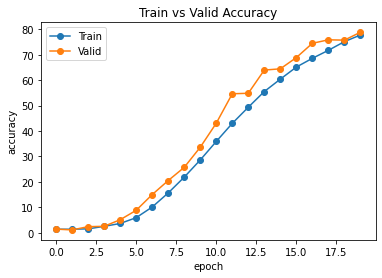

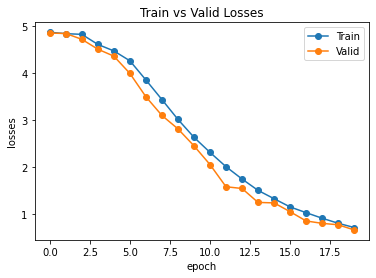

In [ ]:
optimizer = torch.optim.SGD(cnnModel.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()
epoch = 20
for i in tqdm(range(epoch)):
  train(cnnModel)
  test(cnnModel)

grph_plot(tr_acc, val_acc, tr_loss, val_loss)

val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 11. Loss: 4.755032062530518. Accuracy: 1.3506493506493507


  5%|▌         | 1/20 [03:57<1:15:19, 237.88s/it]

validation loss: 4.8291, validation acc: 1.4450

Epoch: 11. Loss: 4.805680751800537. Accuracy: 1.409681227863046


 10%|█         | 2/20 [07:55<1:11:21, 237.86s/it]

validation loss: 4.8289, validation acc: 1.4450

Epoch: 11. Loss: 4.952910423278809. Accuracy: 1.4427390791027155


 15%|█▌        | 3/20 [11:53<1:07:23, 237.83s/it]

validation loss: 4.8288, validation acc: 1.2112

Epoch: 11. Loss: 4.924304962158203. Accuracy: 1.2939787485242031


 20%|██        | 4/20 [15:51<1:03:25, 237.87s/it]

validation loss: 4.8284, validation acc: 1.4450

Epoch: 11. Loss: 5.023957252502441. Accuracy: 1.447461629279811


 25%|██▌       | 5/20 [19:49<59:27, 237.86s/it]  

validation loss: 4.8283, validation acc: 1.4450

Epoch: 11. Loss: 4.8474249839782715. Accuracy: 1.447461629279811


 30%|███       | 6/20 [23:47<55:29, 237.84s/it]

validation loss: 4.8281, validation acc: 1.4450

Epoch: 11. Loss: 4.880490303039551. Accuracy: 1.4427390791027155


 35%|███▌      | 7/20 [27:44<51:31, 237.78s/it]

validation loss: 4.8280, validation acc: 1.4450

Epoch: 11. Loss: 4.957874298095703. Accuracy: 1.4710743801652892


 40%|████      | 8/20 [31:42<47:33, 237.80s/it]

validation loss: 4.8279, validation acc: 1.4450

Epoch: 11. Loss: 4.868703365325928. Accuracy: 1.4002361275088548


 45%|████▌     | 9/20 [35:40<43:35, 237.76s/it]

validation loss: 4.8279, validation acc: 1.4450

Epoch: 11. Loss: 4.7719011306762695. Accuracy: 1.4663518299881937


 50%|█████     | 10/20 [39:37<39:37, 237.74s/it]

validation loss: 4.8278, validation acc: 1.4450

Epoch: 11. Loss: 4.946883201599121. Accuracy: 1.4262101534828808


 55%|█████▌    | 11/20 [43:35<35:39, 237.67s/it]

validation loss: 4.8278, validation acc: 1.4450

Epoch: 11. Loss: 4.817723274230957. Accuracy: 1.4687131050767415


 60%|██████    | 12/20 [47:33<31:43, 237.90s/it]

validation loss: 4.8277, validation acc: 1.4450

Epoch: 11. Loss: 4.85024356842041. Accuracy: 1.4521841794569068


 65%|██████▌   | 13/20 [51:39<28:01, 240.17s/it]

validation loss: 4.8277, validation acc: 1.4450

Epoch: 11. Loss: 4.883033275604248. Accuracy: 1.423848878394333


 70%|███████   | 14/20 [55:37<23:56, 239.48s/it]

validation loss: 4.8277, validation acc: 1.4450

Epoch: 11. Loss: 4.675884246826172. Accuracy: 1.4049586776859504


 75%|███████▌  | 15/20 [59:34<19:54, 238.91s/it]

validation loss: 4.8276, validation acc: 1.4450

Epoch: 11. Loss: 4.896345615386963. Accuracy: 1.461629279811098


 80%|████████  | 16/20 [1:03:32<15:54, 238.51s/it]

validation loss: 4.8277, validation acc: 1.4450

Epoch: 11. Loss: 4.89035701751709. Accuracy: 1.4521841794569068


 85%|████████▌ | 17/20 [1:07:29<11:54, 238.21s/it]

validation loss: 4.8276, validation acc: 1.4450

Epoch: 11. Loss: 4.934010028839111. Accuracy: 1.4309327036599764


 90%|█████████ | 18/20 [1:11:27<07:56, 238.03s/it]

validation loss: 4.8276, validation acc: 1.4450

Epoch: 11. Loss: 4.849555969238281. Accuracy: 1.463990554899646


 95%|█████████▌| 19/20 [1:15:25<03:57, 237.91s/it]

validation loss: 4.8275, validation acc: 1.4450

Epoch: 11. Loss: 4.810909271240234. Accuracy: 1.4403778040141677


100%|██████████| 20/20 [1:19:22<00:00, 238.14s/it]

validation loss: 4.8275, validation acc: 1.4450



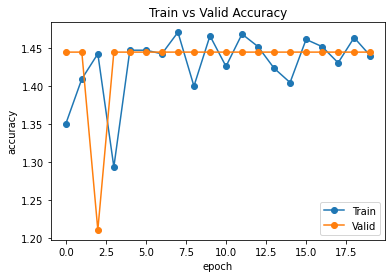

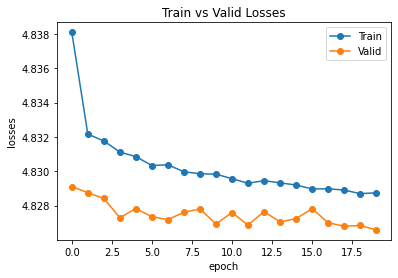

In [ ]:
optimizer = torch.optim.Adam(cnnModel.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
for i in tqdm(range(20)):
  train(cnnModel)
  test(cnnModel)

grph_plot(tr_acc, val_acc, tr_loss, val_loss)

val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

In [ ]:
import random
index = random.randint(0, 10)

test_images, test_labels = next(iter(test_data))

plt.imshow(test_images[index].numpy().transpose((1,2,0)))
plt.show()

# Unsqueeze to allow the "4th" dimension of the image (which is the batch size) to be sent into the model for prediction
network_output = dnet121(test_images[index].to(device).unsqueeze(0))
predicted_label = torch.argmax(network_output)

print("Predicted: ", classes[predicted_label.item()])
print("Actual: ", classes[test_labels[index].item()])
# print("Predicted: ", predicted_label.item())
# print("Actual: ", test_labels[index].item())

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                plt.subplots_adjust(wspace=2, hspace=2)
                ax.axis('off')
                ax.set_title(f'pred:\n {classes[preds[j]]}\nreal:\n {classes[labels[j]]}')
                # ax.set_title(f'predicted: {[preds[j]]}\nactual: {[labels[j]]}')
                imgs = inputs.cpu().data[j] 
                imgs = imgs.numpy().transpose((1, 2, 0))
                imgs = np.clip(imgs, 0, 1)
                ax.imshow(imgs)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(dnet121)

In [ ]:
visualize_model(rnet18)

In [ ]:
visualize_model(gnet)

In [ ]:
visualize_model(cnnModel)

## Save model

In [ ]:
torch.save(dnet121, "torch_model_dnet121.pt")
!ls

drive  herbs  __MACOSX	sample_data  torch_model_dnet121.pt


In [ ]:
torch.save(rnet18, "torch_model_rnet18.pt")
torch.save(gnet, "torch_model_gnet.pt")
torch.save(cnnModel, "torch_model_cnnModel.pt")

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sn
import pandas as pd

model_count = 0
model_arr = ["dnet121", "gnet", "rnet18", "cnnModel"]

def confusion_matrix_model(model):
  global model_count
  y_pred = []
  y_true = []

  # iterate over test data
  for inputs, labels in test_data:
          inputs, labels = inputs.to(device), labels.to(device)
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)

  # calculation
  FP = cf_matrix.sum(axis=0) - np.diag(cf_matrix) 
  FN = cf_matrix.sum(axis=1) - np.diag(cf_matrix)
  TP = np.diag(cf_matrix)
  TN = cf_matrix.sum() - (FP + FN + TP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)
  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy for each class
  ACC = (TP+TN)/(TP+FP+FN+TN)
  # print(ACC)
  print(find_avg(TPR))
  print(find_avg(TNR))
  # print(find_avg(ACC))

  # total = (sum(sum(cf_matrix)))
  # print(cf_matrix[0])

  specificity = TNR.tolist()
  sensitivity = TPR.tolist()
  accura = ACC.tolist()

  res = []
  for l in range(len(classes)):
      prec,recall,_,_ = precision_recall_fscore_support(np.array(y_true)==l,
                                                        np.array(y_pred)==l,
                                                        pos_label=True,average=None)
      res.append([classes[l],recall[0],recall[1], accura[l]])
  # print(res)

  dataframe_spec_sens = pd.DataFrame(res,columns = ['class','specificity','sensitivity','accuracy'])
  dataframe_spec_sens.to_excel("specificity_sensitivity_"+model_arr[model_count] + ".xlsx")
  model_count += 1


In [ ]:
confusion_matrix_model(dnet121)
confusion_matrix_model(gnet)
confusion_matrix_model(rnet18)
confusion_matrix_model(cnnModel)

KeyboardInterrupt: ignored

In [ ]:
dnet121 = torch.load("torch_model_dnet121.pt")
gnet = torch.load("torch_model_gnet.pt")
rnet18 = torch.load("torch_model_rnet18.pt")
cnnModel = torch.load("torch_model_cnnModel.pt")


In [ ]:
def confusion_matrix_model_print(model, index):
  global model_count
  y_pred = []
  y_true = []

  # iterate over test data
  for inputs, labels in test_data:
          inputs, labels = inputs.to(device), labels.to(device)
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  print(cf_matrix[index])


In [ ]:
confusion_matrix_model_print(dnet121, 24)
print(classes[24])
print(classes[5])
print(classes[8])
print(classes[18])

[ 0  0  0  0  0  5  0  0  7  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]
Windproof
Achyranthes
Stemona Tuberosa
Achyranthes


In [ ]:
confusion_matrix_model_print(gnet, 0)
confusion_matrix_model_print(rnet18, 0)
confusion_matrix_model_print(cnnModel, 0)

In [ ]:
def find_avg(T):
  ttl = 0
  
  T = T.tolist()
  size = len(T)
  for i in T:
    ttl += i
  return (ttl/size)
